# 2D dataset
##### The majority of codes except for the model and data preprocessing can be found on NPF ()
#####  Please also cite their work when

In [1]:
import logging
import warnings
import torch
import numpy as np
from tqdm import tqdm
from utils.ntbks_helpers import (get_img_datasets,
                                 add_y_dim)
from utils.data import cntxt_trgt_collate
from functools import partial
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from utils.helpers import count_parameters
import skorch
from npf import ELBOLossLNPF
from npf.neuralproc.gbconpgrid import GridGlobalConvNP
from utils.train import train_models
from utils.evaluate import test_with_loglikelihood, quantify_global_uncertainty
from npf.utils.helpers import make_abs_conv

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    get_all_indcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    no_masker
)
from skorch.callbacks import GradientNormClipping

### Basic setting

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
N_THREADS = 4
torch.set_num_threads(N_THREADS)
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)




### get dataset

In [3]:


# DATASETS
img_datasets, img_test_datasets = get_img_datasets(["MNIST"])

### context-target split

In [4]:
# CONTEXT TARGET SPLIT
# 2d
get_cntxt_trgt_2d = cntxt_trgt_collate(
        GridCntxtTrgtGetter(
            context_masker=RandomMasker(a=0, b=0.3), target_masker=no_masker,
        ),
        is_return_masks=True,  # will be using grid conv CNP => can work directly with mask
    )

### define model

In [5]:
# 2D
########### Original  #################################
R_DIM = 128
MODEL_KWARGS = dict(
    is_q_zCct=True,
    n_z_samples_train=4,
    n_z_samples_test=4,
    r_dim=R_DIM,
    z_dim=R_DIM//2,
    # z_dim = 4,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)

# 2D case
model_2d = partial(
        GridGlobalConvNP,
        x_dim=1,  # for gridded conv it's the mask shape
        # CNN=partial(
        #     CNN,
        #     n_channels=R_DIM,
        #     Conv=torch.nn.Conv2d,
        #     Normalization=torch.nn.BatchNorm2d,
        #     n_blocks=3,
        #     kernel_size=9,
        #     **CNN_KWARGS,
        # ),
        decoder_CNN=partial(
            CNN,
            n_channels=R_DIM,
            Conv=torch.nn.Conv2d,
            Normalization=torch.nn.BatchNorm2d,
            n_blocks=4,
            kernel_size=9,
            **CNN_KWARGS,
        ),
        **MODEL_KWARGS,
    )

n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (2D): {n_params_2d:,d}")

model_2d = add_y_dim(
    {"GBCoNP": model_2d}, img_datasets
)

Number Parameters (2D): 343,921


### load trainer

In [6]:
KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF, # NPML
    chckpnt_dirname="results/pretrained/",
    device=device,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=32,  # smaller batch because multiple samples
    callbacks=[
        GradientNormClipping(gradient_clip_value=1)
    ],  # clipping gradients can stabilize training
)

# 2D
trainers_2d = train_models(
    img_datasets,
    model_2d,
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    max_epochs=5,
    **KWARGS
)


--- Loading MNIST/GBCoNP/run_0 ---

MNIST/GBCoNP/run_0 | best epoch: 39 | train loss: -2858.3912 | valid loss: -2976.4865 | test log likelihood: 2743.51


### Test target log-likelihood

In [11]:
for k, trainer in trainers_2d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
    df = test_with_loglikelihood(img_test_datasets[kernel], trainer)

testing on: MNIST


100%|██████████| 8/8 [00:01<00:00,  6.64it/s]

for 6 runs, mean: 2.6255, std:0.1788


### Evaluate the scale of global uncertainty ($\mu_z, \sigma_z$ )

In [12]:
for k, trainer in trainers_2d.items():
    kernel = k.split('/')[0]
    modelname = k.split('/')[1]
    print("testing on:", kernel)
    df = quantify_global_uncertainty(img_test_datasets[kernel], trainer)


testing on: MNIST


100%|██████████| 8/8 [00:01<00:00,  6.25it/s]

for 6 runs, mean: -0.0018, std:0.2928


### Model prediction sample

now with dataset:MNIST, model:GBCoNP
now with dataset:MNIST, model:GBCoNP
now with dataset:MNIST, model:GBCoNP
now with dataset:MNIST, model:GBCoNP


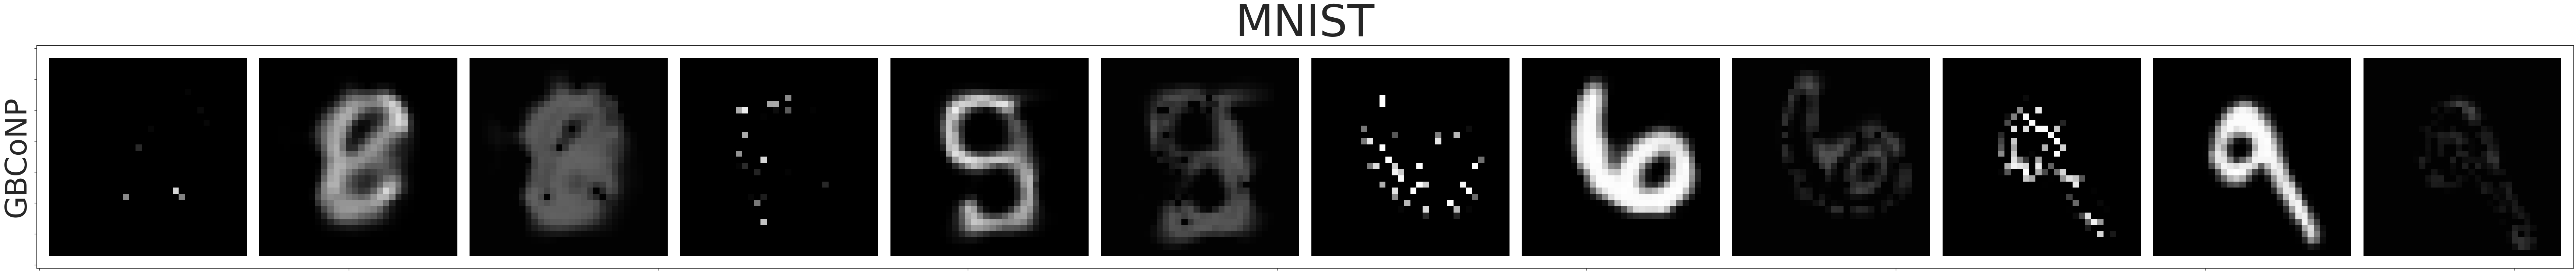

In [7]:
from utils.visualize.visualize_imgs import np_input_to_img
from torchvision import transforms
from PIL import Image

def batch2numpy(x):
    return x.detach().cpu().numpy()


def plot_img_by_dataset(trainers_2d, data, namelist, modellist, n_subplot=1):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    sns.set_theme(style="ticks", color_codes=True)

    def generate_z_sample(z_dist, n_z_sample=1):
        z_mean = z_dist.mean
        z_std_gt = z_dist.stddev
        rand_index = np.random.randint(z_std_gt.shape[-1])
        z_std = torch.zeros(z_mean.shape).to(device)
        if len(z_std.shape) == 3:
            z_std[:,:,rand_index] = z_std[:,:,rand_index]
        else:
            z_std[:, :, :, rand_index] = z_std[:, :, :, rand_index]
        z_range = np.arange(0, 2, 2(n_z_sample//2))
        z_samples = [z_mean + z_std*(z_range[-1] - i) for i in z_range] + [z_mean - z_std*i for i in z_range]
        z_samples = torch.stack(z_samples, dim=0)
        return z_samples

    def preprocess_image(dataname, dataset):
        imgs = dataset.data
        rand_index = np.random.randint(len(imgs))
        img = imgs[rand_index]
        if dataname == 'MNIST':
            img_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
            img = Image.fromarray(img.numpy(), mode='L')
            img = img_transform(img)
        elif dataname == 'SVHN':
            img_transform = transforms.ToTensor()
            img = Image.fromarray(np.transpose(img, (1, 2, 0)))
            img = img_transform(img)
        elif dataname == 'CelebA32': # it's already a ImageFolder
            img = img[0]
        img = img.unsqueeze(0)
        return img, rand_index


    def build_customized_mnist(dataset, dataname, mask_prob):
        img_to_np_input = GridCntxtTrgtGetter(
            context_masker=RandomMasker(a=mask_prob*0.9, b=mask_prob), target_masker=no_masker,
        )
        img, index = preprocess_image(dataname, dataset)
        x_context, y_context, x_target, y_target = img_to_np_input(img)
        return x_context.to(device), y_context.to(device), x_target.to(device), y_target.to(device), index

    def sample_with_global_uncertainty(model, modelname, X_cntxt, Y_cntxt, X_trgt, Y_trgt=None):
        X_cntxt = model.x_encoder(X_cntxt)
        X_trgt = model.x_encoder(X_trgt)
        R = model.encode_globally(X_cntxt, Y_cntxt)
        if model.encoded_path in ["latent", "both"]:
            model.n_z_samples = model.n_z_samples_test
            z_samples, z_samples_mean, q_zCc, q_zCct = model.latent_path(X_cntxt, R, X_trgt, Y_trgt)
            # z_samples = generate_z_sample(q_zCc, 20)
            # if modelname == 'ConvNP':
            #     z_samples = z_samples.repeat(1, 1, R.shape[-3], R.shape[-2], 1)
        else:
            z_samples, z_samples_mean, q_zCc, q_zCct = None, None, None, None

        # size = [n_z_samples, batch_size, *n_trgt, r_dim]
        R_trgt = model.trgt_dependent_representation(X_cntxt, z_samples, R, X_trgt)

        # p(y|cntxt,trgt)
        # batch shape=[n_z_samples, batch_size, *n_trgt] ; event shape=[y_dim]
        p_yCc = model.decode(X_trgt, R_trgt)
        return p_yCc

    for col, (dataname, dataset) in enumerate(data.items()):
        fig, axs = plt.subplots(len(modellist),1, figsize=(100, 10*len(modellist)))
        # load data
        # get one batch
        mask_probs = [0.05, 0.1, 0.15, 0.3]
        grid_by_probs = []
        for mask_prob in mask_probs:
            x_context, y_context, x_target, y_target, img_index = build_customized_mnist(dataset, dataname, mask_prob)
            grid_by_model = []
            for row, modelname in enumerate(modellist):
                x_context_cp = x_context.clone()
                y_context_cp = y_context.clone()
                x_target_cp = x_target.clone()
                y_target_cp = y_target.clone()

                print("now with dataset:%s, model:%s"%(dataname, modelname))
                direct = dataname + '/' + modelname + '/run_0'
                model = trainers_2d[direct].module_.eval().to(device)
                masked_image = np_input_to_img(x_context_cp.clone(), y_context_cp.clone(), dataset.shape)
                if 'Co' in modelname:  # ConvCNP
                    x_context_cp = np_input_to_img(x_context_cp, torch.ones(y_context_cp.shape), dataset.shape).bool()
                    x_context_cp = x_context_cp.permute(0, 2, 3, 1).to(device)
                    y_context_cp = masked_image.clone().permute(0, 2, 3, 1).to(device)
                    x_target_cp = np_input_to_img(x_target_cp, torch.ones(y_target_cp.shape), dataset.shape).bool()
                    x_target_cp = x_target_cp.permute(0, 2, 3, 1).to(device)
                    y_target_cp = y_target_cp.permute(0, 2, 1).view(-1, *dataset.shape)
                    y_target_cp = y_target_cp.permute(0, 2, 3, 1).to(device)

                dist = sample_with_global_uncertainty(model, modelname, x_context_cp, y_context_cp, x_target_cp)
                # dist, sample, z_dist, _ = model(x_context_cp, y_context_cp, x_target_cp)
                # if modelname == 'NN' or 'CNP' in modelname:  # plot conditional methods by 3 samples, 9 figures in total
                # [masked_context, predicted_mean, predicted_std]*3 batch
                y_mean = dist.mean[0] # (bs, n_target, y_dim)
                y_std = dist.stddev[0]
                if 'Co' not in modelname:  # ConvCNP
                    y_mean = y_mean.permute(0, 2, 1).view(-1, *dataset.shape)
                    y_std = y_std.permute(0, 2, 1).view(-1, *dataset.shape)
                else:
                    y_mean = y_mean.permute(0, 3, 1, 2)
                    y_std = y_std.permute(0, 3, 1, 2)
                grid_image = torch.cat([masked_image.unsqueeze(0).cpu(), y_mean.unsqueeze(0).cpu(), y_std.unsqueeze(0).cpu()], dim=0)
                grid_image = grid_image.permute(1, 0, 2, 3, 4).contiguous().view(-1, *dataset.shape)
                # (3, *image_shape): (masked_img + mean + std)
                grid_by_model.append(grid_image)
            grid_by_model = torch.stack(grid_by_model, dim=0) # (n_models, 3, *image_shape)
            grid_by_probs.append(grid_by_model)
        grid_by_probs = torch.stack(grid_by_probs, dim=0) #(len(probs), n_models, 3, *image_shape)
        grid_by_model = grid_by_probs.transpose(0, 1) #(n_models,  len(probs), 3, *image_shape)
        for row, modelname in enumerate(modellist):
            ax = axs[row] if len(modellist) !=1 else axs
            img_recover = grid_by_model[row]
            img_recover = img_recover.contiguous().view(-1, *dataset.shape) #(len(probs)*3, *shape)
            img_recover = make_grid(img_recover, nrow=img_recover.shape[0], pad_value=1.).permute(1, 2, 0)
            ax.imshow(img_recover.detach().numpy())
            ax.set_ylabel("%s" % modelname.split('_')[0], size=80)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if row == 0: # first ax
                ax.set_title(dataname, {'fontsize': 120})
        plt.tight_layout()
        # fig.savefig('results/imgs/'+dataname + ".png")
        plt.show()
        plt.close(fig)

plot_img_by_dataset(trainers_2d, img_test_datasets, namelist=['GBCoNP'], modellist=['GBCoNP'])

### Manipulation of the functional priors
have to reload model as the dimension of the global uncertainty is reduced to 4 for visualzation

In [23]:
def compute_likelihood(mean, var, y_target, issum=True):
    from torch.distributions import Normal
    dist = Normal(loc=mean, scale=var)

    if mean.shape[0] != y_target.shape[0]:  # z_sample
        y_target = y_target.expand(mean.size())
    log_prob = dist.log_prob(y_target)
    loss = torch.mean(log_prob, dim=-2)[:, 0]
    n_row = int(np.sqrt(loss.shape[0]))
    loss = batch2numpy(loss.reshape((n_row, n_row)))
    return loss

def visualize_img_global_uncertainty(trainers_2d, data, namelist, modellist, n_subplot=1):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    sns.set_theme(style="ticks", color_codes=True)
    from torchvision.utils import make_grid
    
    def generate_z_sample(z_dist, n_z_sample=1):
        z_mean = z_dist.mean
        z_std = z_dist.stddev
        bs, *data_shape, dim = z_mean.shape
        # rand_index = np.random.choice(np.arange(0, dim, 1), 2, replace=False)  # non-replacement shuffle
        rand_index = [2, 3]
        print("index combo:", rand_index)
        z_grid = z_mean[None, None, :].repeat(n_z_sample, n_z_sample, 1, *data_shape, 1)
        if len(data_shape) >1:
            x = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, 0, rand_index[0]].detach().cpu().numpy(),
                         scale=30*z_std[0, 0, 0, rand_index[0]].detach().cpu().numpy())
            y = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample),
                         loc=z_mean[0, 0, 0, rand_index[1]].detach().cpu().numpy(),
                         scale=30*z_std[0, 0, 0, rand_index[1]].detach().cpu().numpy())
        else:
            x = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample), loc=z_mean[0,0,rand_index[0]].detach().cpu().numpy(),
                         scale=40*z_std[0, 0, rand_index[0]].detach().cpu().numpy())
            y = norm.ppf(np.linspace(0.05, 0.95, num=n_z_sample), loc=z_mean[0,0,rand_index[1]].detach().cpu().numpy(),
                         scale=40*z_std[0, 0, rand_index[1]].detach().cpu().numpy())
        l_x = x.shape[0]
        l_y = y.shape[0]
        x_grid = np.repeat(x, l_y).reshape(-1, 1)
        y_grid = np.tile(y, l_x).reshape(-1, 1)
        _z = np.concatenate([x_grid, y_grid], axis=1)
        for i in range(n_z_sample):
            for j in range(n_z_sample):
                if len(data_shape) > 1: # image input
                    z_grid[i, j, :, :, :, rand_index[0]] = _z[i * n_z_sample + j, 0]
                    z_grid[i, j, :, :, :, rand_index[1]] = _z[i * n_z_sample + j, 1]
                else:
                    z_grid[i, j, :, :, rand_index[0]] = _z[i*n_z_sample+j, 0]
                    z_grid[i, j, :, :, rand_index[1]] = _z[i * n_z_sample + j, 1]
        z_samples = z_grid.view(n_z_sample*n_z_sample, bs, *data_shape, dim)
        return z_samples, rand_index

    def sample_with_global_uncertainty(model, modelname, X_cntxt, Y_cntxt, X_trgt, Y_trgt=None):
        X_cntxt = model.x_encoder(X_cntxt)
        X_trgt = model.x_encoder(X_trgt)
        R = model.encode_globally(X_cntxt, Y_cntxt)


        if model.encoded_path in ["latent", "both"]:
            model.n_z_samples = model.n_z_samples_test
            z_samples, z_samples_mean, q_zCc, q_zCct = model.latent_path(X_cntxt, R, X_trgt, Y_trgt)
            temp1 = q_zCc.mean.detach().cpu().numpy()
            temp2 = q_zCc.stddev.detach().cpu().numpy()
            z_samples, zdim_index = generate_z_sample(q_zCc, 10)
            if 'Co' in modelname:
                z_samples = z_samples.repeat(1, 1, R.shape[-3], R.shape[-2], 1)
        else:
            z_samples, z_samples_mean, q_zCc, q_zCct = None, None, None, None

        # size = [n_z_samples, batch_size, *n_trgt, r_dim]
        R_trgt = model.trgt_dependent_representation(X_cntxt, z_samples, R, X_trgt)

        # p(y|cntxt,trgt)
        # batch shape=[n_z_samples, batch_size, *n_trgt] ; event shape=[y_dim]
        p_yCc = model.decode(X_trgt, R_trgt)
        return p_yCc, zdim_index

    def preprocess_image(dataname, dataset):
        if dataname == 'MNIST':
            digit = 6
            indices = dataset.targets == digit
            imgs = dataset.data[indices]
            rand_index = np.random.randint(len(imgs))
            img = imgs[rand_index]
            img_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
            img = Image.fromarray(img.numpy(), mode='L')
            img = img_transform(img)
        elif dataname == 'SVHN':
            digit = ''
            imgs = dataset.data
            rand_index = np.random.randint(len(imgs))
            img = imgs[rand_index]
            img_transform = transforms.ToTensor()
            img = Image.fromarray(np.transpose(img, (1, 2, 0)))
            img = img_transform(img)
        elif dataname == 'CelebA32':  # it's already a ImageFolder
            digit = ''
            imgs = dataset.data
            rand_index = np.random.randint(len(imgs))
            img = imgs[rand_index]
            img = img[0]
        img = img.unsqueeze(0)
        return img, rand_index, digit

    def get_random_image(dataname, dataset):
        img_to_np_input = GridCntxtTrgtGetter(
            context_masker=RandomMasker(a=0, b=0.3), target_masker=no_masker,
        )
        img, rand_index, digit = preprocess_image(dataname, dataset)
        x_context, y_context, x_target, y_target = img_to_np_input(img)
        return x_context.to(device), y_context.to(device), x_target.to(device), y_target.to(device), rand_index, digit

    for col, (dataname, dataset) in enumerate(data.items()):
        fig, axs = plt.subplots(len(modellist), 1, figsize=(20, 20 * len(modellist)))
        # load data
        # get one batch
        x_context, y_context, x_target, y_target, img_index, digit = get_random_image(dataname, dataset)

        for row, modelname in enumerate(modellist):
            x_context_cp = x_context.clone()
            y_context_cp = y_context.clone()
            x_target_cp = x_target.clone()
            y_target_cp = y_target.clone()

            ax = axs if len(modellist) == 1 else axs[row]
            print("now with dataset:%s, model:%s" % (dataname, modelname))
            direct = dataname + '/' + modelname + '/run_0'
            model = trainers_2d[direct].module_.eval().to(device)
            masked_image = np_input_to_img(x_context_cp.clone(), y_context_cp.clone(), dataset.shape)
            if 'Co' in modelname:  # ConvCNP
                x_context_cp = np_input_to_img(x_context_cp, torch.ones(y_context_cp.shape), dataset.shape).bool()
                x_context_cp = x_context_cp.permute(0, 2, 3, 1).to(device)
                y_context_cp = masked_image.clone().permute(0, 2, 3, 1).to(device)
                x_target_cp = np_input_to_img(x_target_cp, torch.ones(y_target_cp.shape), dataset.shape).bool()
                x_target_cp = x_target_cp.permute(0, 2, 3, 1).to(device)
                y_target_cp = y_target_cp.permute(0, 2, 1).view(-1, *dataset.shape)
                y_target_cp = y_target_cp.permute(0, 2, 3, 1).to(device)

            dist, zdim_index = sample_with_global_uncertainty(model, modelname, x_context_cp, y_context_cp, x_target_cp)
            # dist, sample, z_dist, _ = model(x_context_cp, y_context_cp, x_target_cp)
            # [masked_context, predicted_mean*7, predicted_std]
            y_mean = dist.mean[:, 0, :, :]  # (n_z_sample, n_target, y_dim)
            y_std = dist.stddev[:, 0, :, :]
            
            loglikelihood = compute_likelihood(y_mean, y_std, y_target_cp, issum=False)
            
            if 'Co' not in modelname:  # ConvCNP
                y_mean = y_mean.permute(0, 2, 1).view(-1, *dataset.shape)
                y_std = y_std.permute(0, 2, 1).view(-1, *dataset.shape)
            else:
                y_mean = y_mean.permute(0, 3, 1, 2)
                y_std = y_std.permute(0, 3, 1, 2)
            # only the last sample comes with std
            grid_image = y_mean.cpu()

            # replace the first element with the masked image
            grid_image[0] = masked_image[0]

            img_recover = make_grid(grid_image, nrow=10, pad_value=1.).permute(1, 2, 0)
            ax.imshow(img_recover.detach().numpy())
            ax.set_ylabel("%s" % modelname.split('_')[0], size=50)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            if row == 0:  # first ax
                ax.set_title(dataname, {'fontsize': 50})
        plt.tight_layout()
        # fig.savefig('results/imgs/digits/'+ str(digit) +'_img'+str(img_index) + 'zdim'+str(zdim_index[0]) +str(zdim_index[1])+".png")
        plt.show()
        plt.close(fig)
        
        
        # draw log-likelihood heatmap
        fig, axs = plt.subplots(figsize=(50, 20))
        sns.set(font_scale=2) # font size 2
        res = sns.heatmap(loglikelihood,   annot=True, 
                    annot_kws={"size":50},
                    fmt=".2f")
        res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 50)
        res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 50)
        

In [24]:
sample_size = 10
R_DIM = 128
KWARGS = dict(
    is_q_zCct=True,  # will use NPVI => posterior sampling
    n_z_samples_train=sample_size,
    n_z_samples_test=sample_size,
    r_dim=R_DIM,
    z_dim=4,
    # z_dim=R_DIM//2,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


model_2d = partial(
                GridGlobalConvNP,
                x_dim=1,  # for gridded conv it's the mask shape
                decoder_CNN=partial(
                    CNN,
                    n_channels=R_DIM,
                    Conv=torch.nn.Conv2d,
                    Normalization=torch.nn.BatchNorm2d,
                    n_blocks=4,
                    kernel_size=9,
                    **CNN_KWARGS,
                ),
                **KWARGS,
            )

modeldict = dict()
modelname = 'GBCoNP_zdim4'
datasetname = 'MNIST'
modeldict[modelname] = partial(model_2d, y_dim=img_test_datasets[datasetname].shape[0])




--- Loading MNIST/GBCoNP_zdim4/run_0 ---

MNIST/GBCoNP_zdim4/run_0 | best epoch: 21 | train loss: -2840.7081 | valid loss: -2849.15 | test log likelihood: 2759.2803
now with dataset:MNIST, model:GBCoNP_zdim4
index combo: [2, 3]


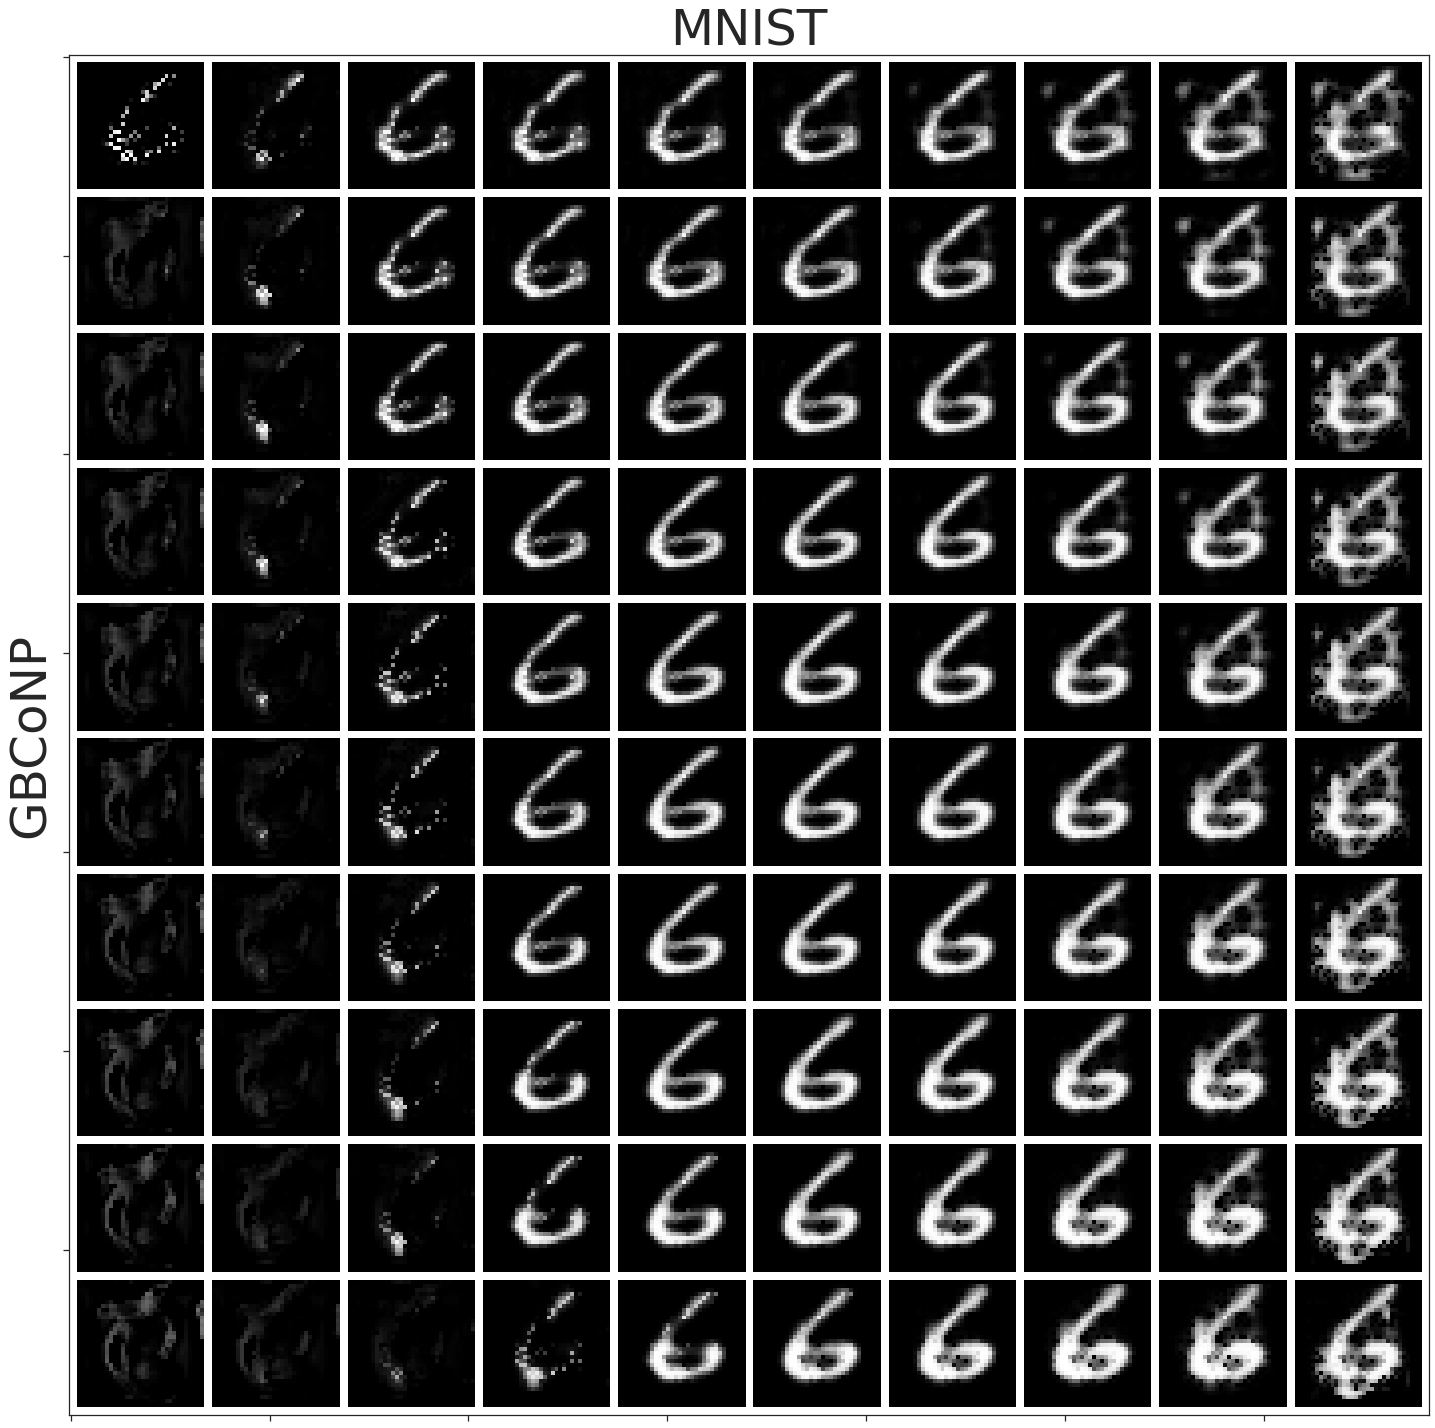

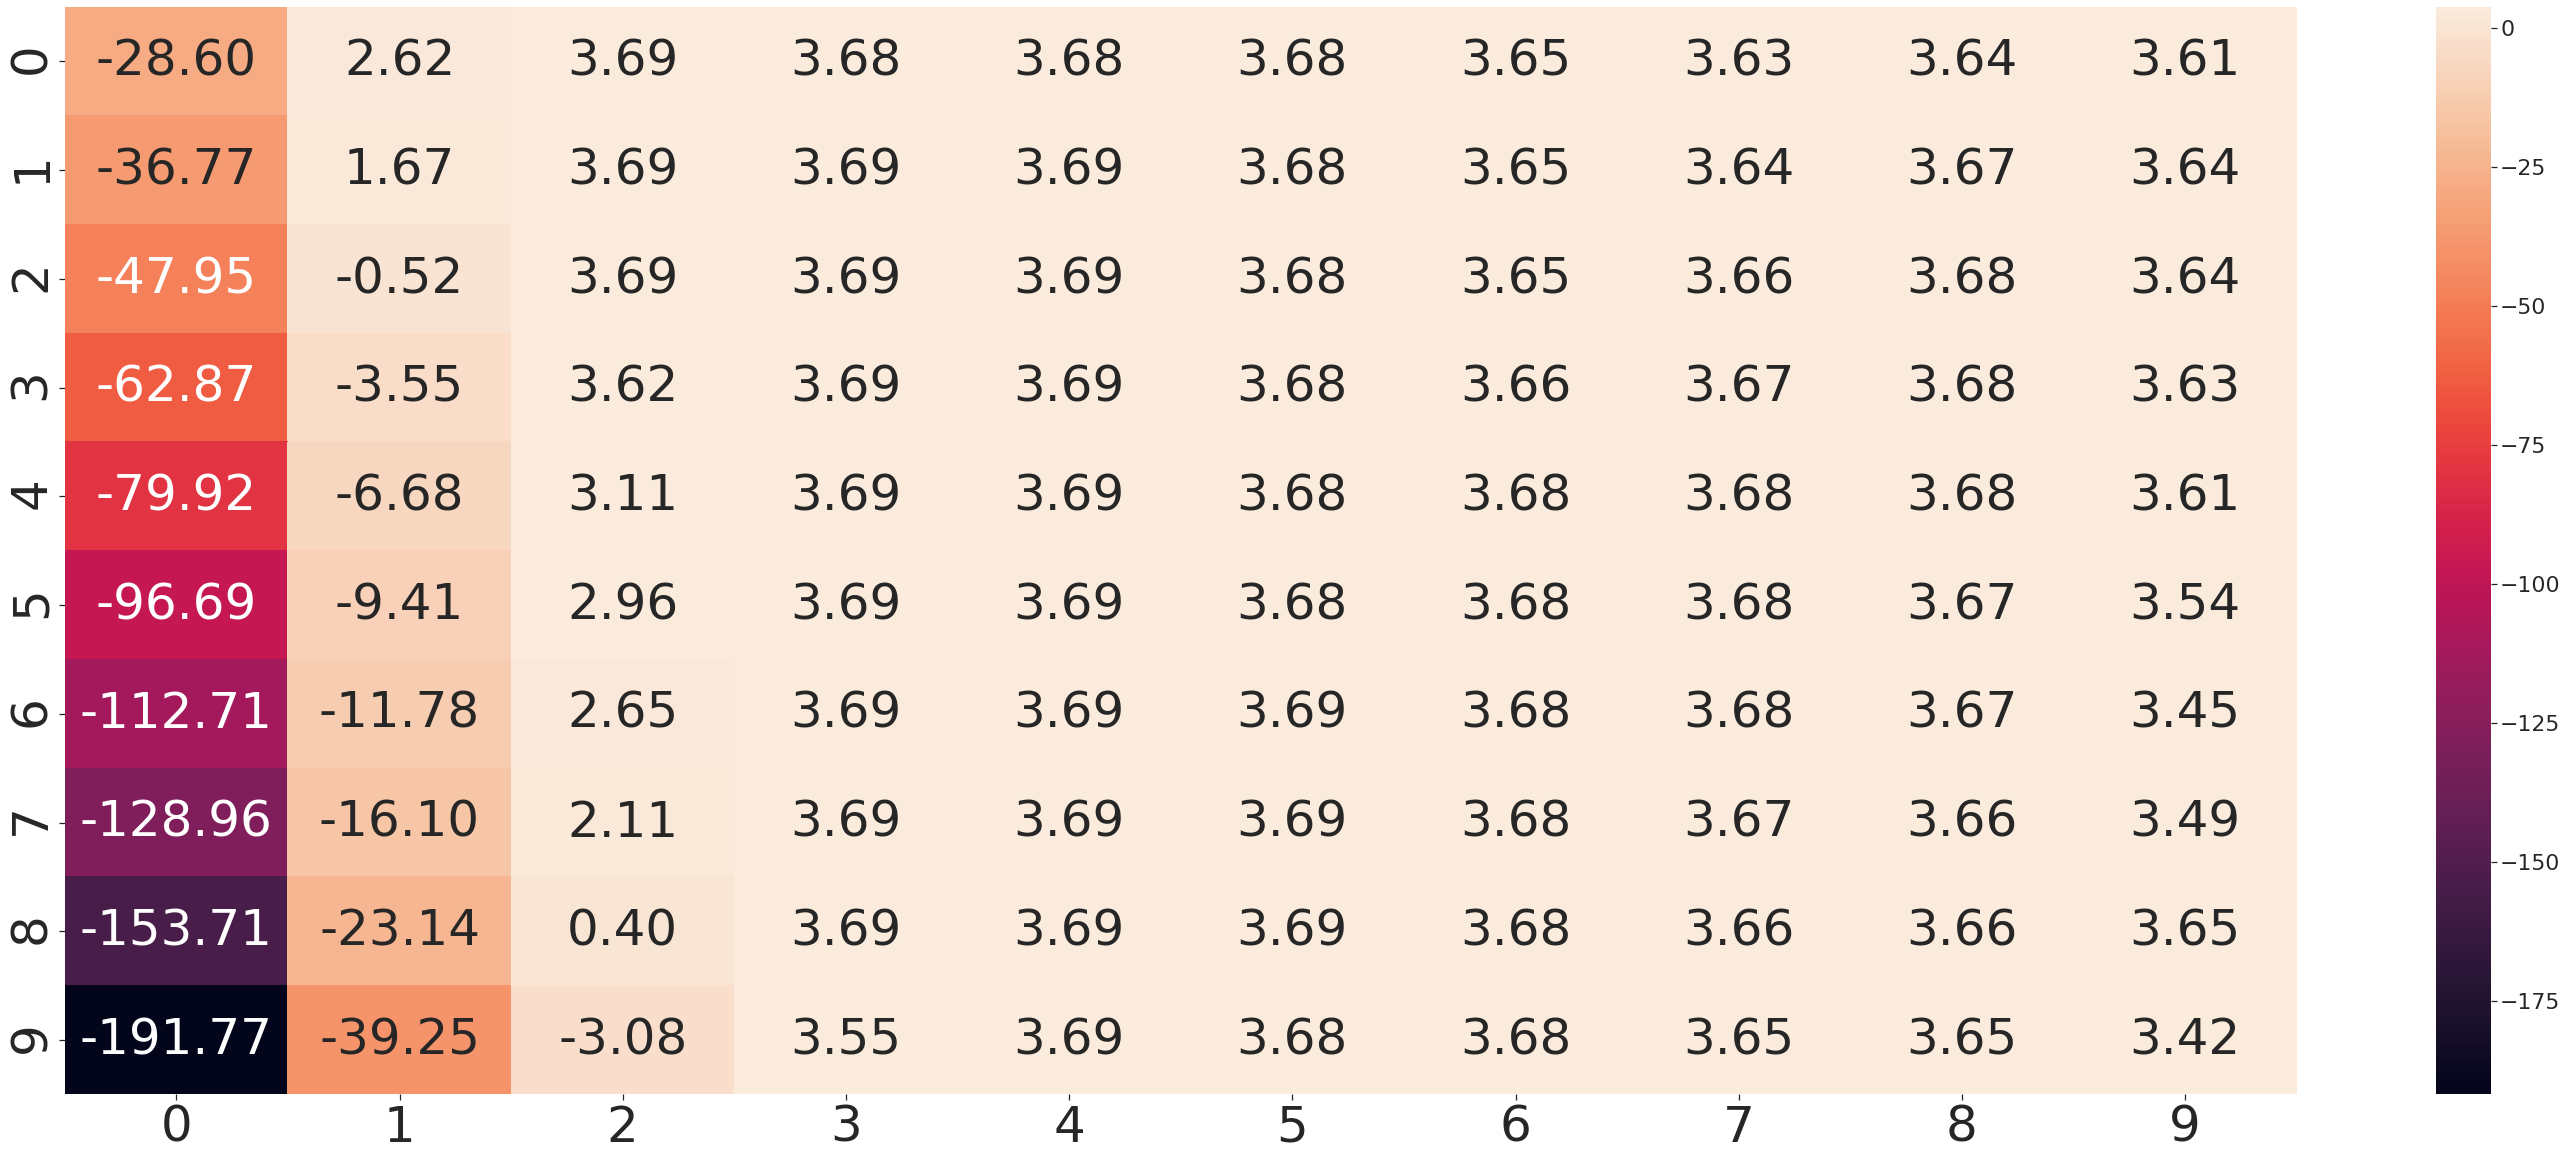

In [25]:
KWARGS = dict(
        is_retrain=False,  # whether to load precomputed model or retrain
        criterion=ELBOLossLNPF,
        chckpnt_dirname="results/pretrained/",
        device=device,  # use GPU if available
        batch_size=1,
        lr=1e-3,
        decay_lr=10,  # decrease learning rate by 10 during training
        # seed = 123,
    )


get_cntxt_trgt_2d = cntxt_trgt_collate(
        GridCntxtTrgtGetter(
            context_masker=RandomMasker(a=0.1, b=0.2), target_masker=no_masker,
        )
    )

# 2D
trainers_2d = train_models(
        img_test_datasets,
        modeldict,
        test_datasets=img_test_datasets,
        train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
        iterator_train__collate_fn=get_cntxt_trgt_2d,
        iterator_valid__collate_fn=get_cntxt_trgt_2d,
        max_epochs=50,
        **KWARGS
    )

visualize_img_global_uncertainty(trainers_2d, img_test_datasets, namelist=['GBCoNP'], modellist=['GBCoNP_zdim4'])